# Notebook for inferring predictions and comparing model performance

## Import models and functions needed

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_definitions import KmerCountsModel, FCNNEmbedding
from utils.load_splits import load_splits
from utils.decode_kmer import decode_kmer

## Iterate over data versions, load in both benchmark and neural network models, predict over test set, save losses in dictionary

In [2]:
DATA_VERSION = ["3fA", "5fA", "7fA", "9fA"]

benchmark_losses = {}
nn_losses = {}

for version in DATA_VERSION:
    _, _, _, _, _, _, X_test, _, y_test = load_splits(version)

    X_test_decoded = decode_kmer(X_test)
    y_test_decoded = decode_kmer(y_test)

    model_benchmark = KmerCountsModel.load(f"/faststorage/project/MutationAnalysis/Nimrod/results/models/counts_benchmark/{version}/model.pkl")
    loss_benchmark = model_benchmark.evaluate(X_test_decoded, y_test_decoded)

    benchmark_losses[version] = loss_benchmark

    def onehot_to_indexed_kmers(onehot_data):
        """
        Function to convert one-hot encoding to integer encoding for nn.Embedding()
        by reshaping k-mer to (data_size, kmer_length, mut_outcomes=4) then taking
        argmax
        """

        data_size = onehot_data.size(0)
        kmer_length = onehot_data.size(1) // 4

        reshaped = onehot_data.view(data_size, kmer_length, 4)

        indexed = reshaped.argmax(dim=2)
        return indexed.long()
    
    X_test = onehot_to_indexed_kmers(X_test)

    model_nn = FCNNEmbedding(num_embeddings=4, embedding_dim=32)
    model_nn.load_state_dict(torch.load(f"/faststorage/project/MutationAnalysis/Nimrod/results/models/fc/{version}/model.pth"))

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    test_probs = []
    test_targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            probs = model_nn.predict_proba(xb)

            test_probs.append(probs.cpu())
            test_targets.append(yb.cpu())

    test_probs = torch.cat(test_probs).numpy()
    test_targets = torch.cat(test_targets).numpy()

    loss_nn = log_loss(test_targets, test_probs)
    nn_losses[version] = loss_nn
    print(f"Test log loss of neural network: {loss_nn}")

Test log loss of neural network: 0.5041914787533972
Test log loss of neural network: 0.49665212556479527


/home/grnimrod/miniforge3/envs/mutation-probs-nn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test log loss of neural network: 0.4941128064224417


/home/grnimrod/miniforge3/envs/mutation-probs-nn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Test log loss of neural network: 0.4934357685903996


Running the evaluation code takes around 14 minutes

In [3]:
print(benchmark_losses)
print(nn_losses)

{'3fA': 0.5034450339817884, '5fA': 0.4956557251721156, '7fA': 0.5315531640424588, '9fA': 1.8798635955666005}
{'3fA': 0.5041914787533972, '5fA': 0.49665212556479527, '7fA': 0.4941128064224417, '9fA': 0.4934357685903996}


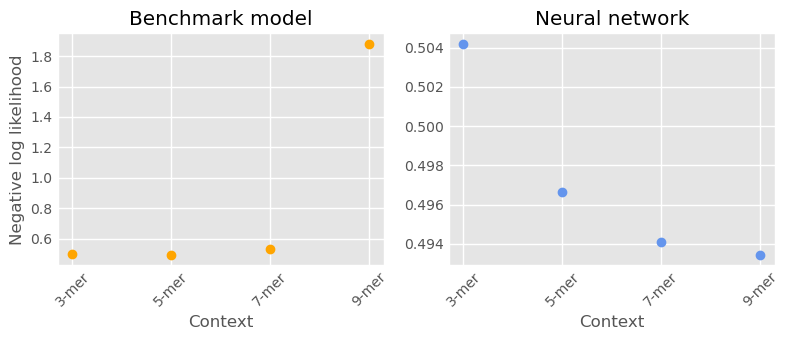

In [29]:
results_df = pd.DataFrame({
    "Benchmark model": benchmark_losses,
    "Neural network": nn_losses
})

plt.style.use("ggplot")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

# Plot benchmark values
axes[0].plot(["3-mer", "5-mer", "7-mer", "9-mer"], results_df["Benchmark model"], 'o', color='orange')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title("Benchmark model")
axes[0].set_xlabel("Context")
axes[0].set_ylabel("Negative log likelihood")

# Plot neural network values
axes[1].plot(["3-mer", "5-mer", "7-mer", "9-mer"], results_df["Neural network"], 'o', color='cornflowerblue')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title("Neural network")
axes[1].set_xlabel("Context")

# Improve layout
plt.tight_layout()
plt.show()

## Create "mutation outcomes per k-mer type" figure
### Generate list of each possible k-mer context
Only suitable for 3-mers due to number of possible k-mers with higher length

In [ ]:
DATA_VERSION = "3fA"

version_map = {
        "3fA": "3mer_full_A",
        "3fC": "3mer_full_C",
        "3sA": "3mer_subset_A",
        "3sC": "3mer_subset_C",
        "5fA": "5mer_full_A",
        "5fC": "5mer_full_C",
        "7fA": "7mer_full_A",
        "7fC": "7mer_full_C",
        "9fA": "9mer_full_A",
        "9fC": "9mer_full_C",
        "11fA": "11mer_full_A",
        "11fC": "11mer_full_C",
        "13fA": "13mer_full_A",
        "13fC": "13mer_full_C",
        "15fA": "15mer_full_A",
        "15fC": "15mer_full_C",
        "15sA": "15mer_subset_A",
        "15sC": "15mer_subset_C",
        "experiment_full": "experiment_full",
        "experiment_subset": "experiment_subset"
    }

df = pd.read_csv(f"/faststorage/project/MutationAnalysis/Nimrod/data/processed/{version_map[DATA_VERSION]}.tsv", sep="\t")

distinct_contexts = df["context"].drop_duplicates().sort_values(ignore_index=True)
distinct_contexts = list(distinct_contexts)

### Use model.predict_proba() to obtain probability distribution of mutation outcomes for each k-mer type

In [ ]:
model = FCNNEmbedding(num_embeddings=4, embedding_dim=32)
model.load_state_dict(torch.load(f"/faststorage/project/MutationAnalysis/Nimrod/results/models/fc/{DATA_VERSION}/model.pth"))

probs = []

def one_hot_encode_3mer(context):
    nucleotides = ['A', 'C', 'G', 'T']
    nuc_to_int = {nuc: i for i, nuc in enumerate(nucleotides)} # Encode nucl to int
    onehot_array = np.concatenate([np.eye(4)[nuc_to_int[nuc]] for nuc in context])
    return torch.as_tensor(onehot_array, dtype=torch.float32)


for context in distinct_contexts:
    context_onehot = one_hot_encode_3mer(context)
    model.eval()
    with torch.no_grad():
        prob_distr = model.predict_proba(context_onehot).detach().numpy()
        probs.append(prob_distr)

nucleotides = ['A', 'C', 'G', 'T']
probs = pd.DataFrame(probs, columns=nucleotides, index=distinct_contexts)
probs

,A,C,G,T
AAAAA,0.918009,0.019695,0.049612,0.012684
AAAAC,0.932160,0.019248,0.034156,0.014435
AAAAG,0.919127,0.024437,0.042907,0.013529
AAAAT,0.918691,0.024032,0.034005,0.023273
AAACA,0.886547,0.017345,0.076713,0.019395
...,...,...,...,...
TTAGT,0.873586,0.031941,0.072503,0.021970
TTATA,0.790410,0.016034,0.154482,0.039075
TTATC,0.817766,0.020132,0.115807,0.046295
TTATG,0.816581,0.020348,0.117160,0.045911


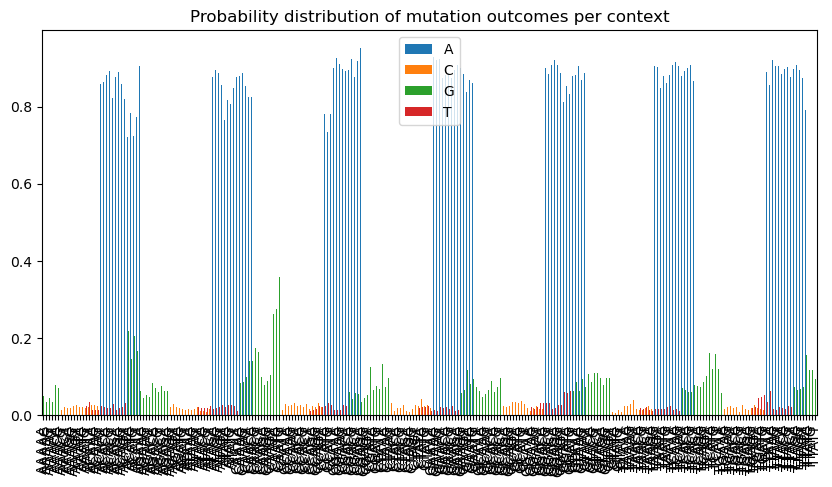

In [7]:
probs.plot(kind="bar", figsize=(10, 5))
plt.title("Probability distribution of mutation outcomes per context")
plt.show()